In [69]:
import numpy as np
import pandas as pd
import keras
from keras.models import Model
from keras.layers import Input,Dense,Flatten
from keras.layers import LSTM
from numpy import array
import matplotlib.pyplot as plt 

# function

In [2]:
#define normalization
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

#define the feature and label
def train_(df, ref_day, predict_day):
    X_train, Y_train = [], []
    for i in range(df.shape[0]+predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,0:4]))
        Y_train.append(np.array(df.iloc[i+ref_day : i+ref_day+predict_day,4]))
    return np.array(X_train), np.array(Y_train)

#define the denormalization
def denormalize(train):
    denorm = train*(np.max(data_train['TWA00']['收盤價'])-np.min(data_train['TWA00']['收盤價']))+np.mean(data_train['TWA00']['收盤價'])
    return denorm

## read data from .csv

In [3]:
df_train = pd.read_csv('./Train_X.csv',encoding= 'cp950')
df_test = pd.read_csv('./Test_X.csv',encoding= 'cp950')

In [4]:
data_train = {}
data_test ={}

# feature engineering

### 使用 開盤價 最高價 最低價 成交量來當作 feature

In [5]:
df_train = df_train.sort_values('日期')
df_test = df_test.sort_values('日期')
stock_list_train = (df_train['股票代號'].unique()).tolist()


#collect data for dictionary format
for name in stock_list_train:
    data_test[name]=df_test[df_test['股票代號']==name].loc[:,['開盤價', '最高價','最低價','成交量.股.','收盤價']]

    for name in stock_list_train:
    data_train[name]=df_train[df_train['股票代號']==name].loc[:,['開盤價', '最高價','最低價','成交量.股.','收盤價']]
    
TWA00_test= normalize(data_test['TWA00'])
TWA00_train= normalize(data_train['TWA00'])


# setting data for training
### 每5天做成一筆training data 預測第6天

In [6]:
X_train,Y_train=train_(TWA00_train,5,1)
X_test,Y_test=train_(TWA00_test,5,1)


x_train = np.delete(X_train,232,0)
y_train = np.empty([232,1,1], dtype=float)
for k in range(232):
    y_train[k] = Y_train[k]


y_train = y_train.reshape(232,1)

real_price = denormalize(TWA00_test['收盤價']).tolist()

# # define model

In [47]:
# define model

units = 500
inputs1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm1=LSTM(units, activation='relu', recurrent_activation='hard_sigmoid',return_sequences=True,dropout=0.3)(inputs1)
lstm2=LSTM(units, activation='relu', recurrent_activation='hard_sigmoid',return_sequences=True,dropout=0.3)(lstm1)
lstm3=LSTM(units, activation='relu', recurrent_activation='hard_sigmoid',return_sequences=True,dropout=0.3)(lstm2)
final=LSTM(1, activation='tanh', recurrent_activation='hard_sigmoid',return_sequences = False)(lstm3)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.99, beta_2=0.999, amsgrad=False)

model = Model(inputs=inputs1, outputs=final)
model.compile(optimizer=adam, loss='mean_squared_error')

# model training

In [48]:
model.fit(x_train,y_train,epochs = 200, batch_size = 20)

Epoch 1/200
232/232 [==============================] - 9s 38ms/step - loss: 0.0423
Epoch 2/200
232/232 [==============================] - 4s 18ms/step - loss: 0.0180
Epoch 3/200
232/232 [==============================] - 4s 18ms/step - loss: 0.0148
Epoch 4/200
232/232 [==============================] - 4s 19ms/step - loss: 0.0156
Epoch 5/200
232/232 [==============================] - 4s 18ms/step - loss: 0.0117
Epoch 6/200
232/232 [==============================] - 4s 18ms/step - loss: 0.0128
Epoch 7/200
232/232 [==============================] - 4s 18ms/step - loss: 0.0121
Epoch 8/200
232/232 [==============================] - 5s 20ms/step - loss: 0.0104
Epoch 9/200
232/232 [==============================] - 4s 19ms/step - loss: 0.0112
Epoch 10/200
232/232 [==============================] - 5s 20ms/step - loss: 0.0108
Epoch 11/200
232/232 [==============================] - 5s 20ms/step - loss: 0.0096
Epoch 12/200
232/232 [==============================] - 5s 20ms/step - loss: 0.0091
E

232/232 [==============================] - 4s 19ms/step - loss: 0.0027
Epoch 195/200
232/232 [==============================] - 5s 19ms/step - loss: 0.0024
Epoch 196/200
232/232 [==============================] - 4s 19ms/step - loss: 0.0024
Epoch 197/200
232/232 [==============================] - 4s 19ms/step - loss: 0.0024
Epoch 198/200
232/232 [==============================] - 4s 19ms/step - loss: 0.0023
Epoch 199/200
232/232 [==============================] - 4s 19ms/step - loss: 0.0023
Epoch 200/200
232/232 [==============================] - 4s 19ms/step - loss: 0.0022


# compare with training data and predicted data(from training data)

In [66]:
training_data_x = (denormalize(model.predict(x_train)))
train_data_y= (denormalize((y_train)))

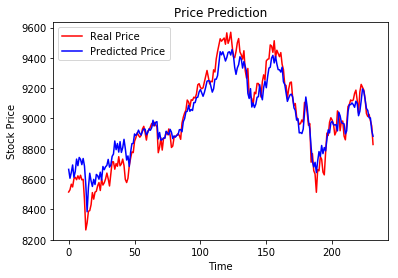

In [67]:
plt.plot(range(len(train_data_y)),train_data_y, color = 'red', label = 'Real Price')  # 紅線表示真實股價
plt.plot(range(len(training_data_x)),training_data_x, color = 'blue', label = 'Predicted Price')  # 藍線表示預測股價
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### 利用前五天來預測第六天的數據，由於需預測12/18-12/31
### 因此需要使用到training data 的部分數據(12/12-12/17 不含六日的五筆數據)
### 藍色部分為新填補的資料

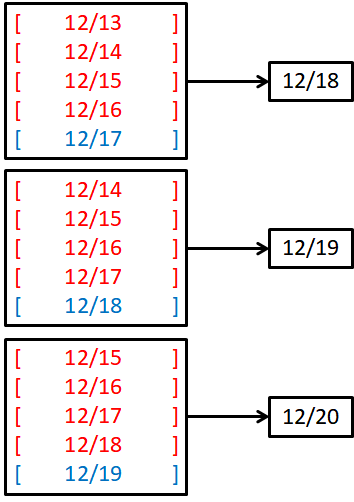

In [70]:
matrix = np.zeros((1,5,4))
trans = X_train[-1].reshape(1,5,4)
Predicted_Price= []
for i in range(10):
    if i<=4 :
        Predicted_Price.append(denormalize(model.predict(trans))[0][0])
        #print('i = ',i ,"\n",trans)
        matrix[0][0:4] = trans[0][1:5] #last data from training data to shift each row to above
        matrix[0][4] = X_test[0][i]
        trans = matrix
    else:
        #print('i = ',i ,"\n",X_test[i-5])
        Predicted_Price.append(denormalize(model.predict(X_test[i-5].reshape(1,5,4)))[0][0])

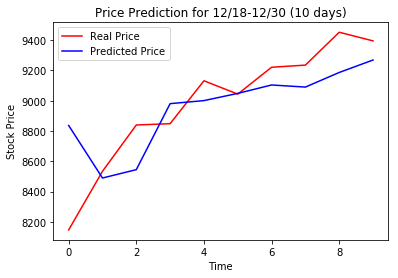

In [72]:

plt.plot(range(10),real_price, color = 'red', label = 'Real Price')  # 紅線表示真實股價
plt.plot(range(10),Predicted_Price, color = 'blue', label = 'Predicted Price')  # 藍線表示預測股價
plt.title('Price Prediction for 12/18-12/30 (10 days)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [81]:
Predicted_Price

[8836.261,
 8489.476,
 8544.733,
 8980.321,
 9000.42,
 9048.021,
 9103.553,
 9089.687,
 9186.118,
 9268.353]

In [75]:
error = np.array(Predicted_Price)-np.array(real_price)

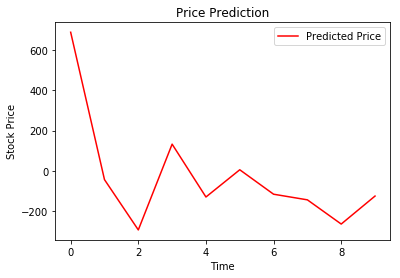

In [80]:
plt.plot(range(len(error)),error, 'r-', label = 'Predicted Price')  # 藍線表示預測股價
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 由上圖可知，雖然於12/18 日時預測數據較為不準，相差接近600點
## 可能原因如下 : 
##     training data 之間過於正相關，由於採用的feature為前五日的最高價與最低價，
##     大部分與收盤價有正相關，因此會造成訓練LSTM 4個 gate時較容易訓練產生誤差

# --------------------------------------------------------------------------------------------------


## 未來可改進部分 : 
## 1. 找出與權指較為相關的股票資料，並取出其法人買賣超加入feature
## 2. 利用Binary classification 做股票分類，將與權指有相關的股票抽出，                                                並選擇其買賣量或者其他資料加入feature